In [1]:
%pip install pysal
%pip install contextily

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: C:\Users\Наталья\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: C:\Users\Наталья\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
%pip install matplotlib
%pip install geopandas
%pip install pandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: C:\Users\Наталья\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: C:\Users\Наталья\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: C:\Users\Наталья\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
# Графика
import matplotlib.pyplot as plt
import seaborn
from pysal.viz import splot
from splot.esda import plot_moran
import contextily as ctx

# Анализ
import geopandas as gpd
import pandas as pd
from pysal.explore import esda
from pysal.lib import weights
from numpy.random import seed

C:\Users\Наталья\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\spaghetti\network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)
C:\Users\Наталья\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_t

In [4]:
# данные


## План показателей
### Доход и потребление
#### Среднедушевой доход населения по МО (или медианный доход)
#### Объём потребительских расходов (по SberIndex)
#### Коэффициент самообеспеченности (доля товаров и услуг, производимых и потребляемых внутри МО) — если можно оценить

### Доступность инфраструктуры
#### Плотность дорожной сети и/или расстояние до ближайшего транспортного узла
#### Доля населения, имеющая доступ к объектам образования, медицины и торговли (в пределах 30 минут на транспорте)

### Демография и занятость
#### Уровень безработицы
#### Численность и плотность населения
#### Миграционный прирост/убыль
#### Возрастная структура (доля трудоспособного населения)

### Финансовые показатели МО
#### Доходы местных бюджетов на душу населения
#### Доля трансфертов от федерального/регионального бюджета
#### Расходы бюджета на социальные нужды (на душу)

### ГЕО
#### Геометрии муниципальных образований
#### Соседства (матрица весов W) — можно вычислить из геометрии
#### Расстояния между центрами МО или их гравитационными центрами

## Baseline

In [5]:
# baseline доходы, расходы, половозростайка потом Глобальный индекс Moran’s I: 0.426, p-value: 0.001
import geopandas as gpd
import pandas as pd

# Загрузка данных
gdf_spending = gpd.read_file("gdf_consumption_for_2023_2024.gpkg")
gdf_salary = gpd.read_file("gdf_salary_for_2023_2024.gpkg")

gdf_spending = gdf_spending
gdf_salary = gdf_salary

# Проверим, что общие ключи совпадают
assert set(gdf_spending["territory_id"]) == set(gdf_salary["territory_id"]), "Несовпадение МО!"

# Объединение по идентификатору территории
gdf_merged = gdf_spending.merge(
    gdf_salary[["territory_id", "mean_salary_for_2023_2024"]],
    on="territory_id"
)

# Вычисляем базовую метрику
gdf_merged["spending_to_salary_ratio"] = (
    gdf_merged["mean_spending_for_2023_2024"] /
    gdf_merged["mean_salary_for_2023_2024"]
)


In [6]:
# бюджетная обеспеченность по регионам
df_budget = pd.read_excel("Уровень_бюджетной_обеспеченности_Таблица_2025_06_07.xlsx")

df_budget_cleaned = df_budget.copy()
df_budget_cleaned = df_budget_cleaned[df_budget_cleaned["Субъекты Российской Федерации"].notna()]
df_budget_cleaned = df_budget_cleaned[~df_budget_cleaned["Субъекты Российской Федерации"].str.contains("федеральный округ", case=False, na=False)]
df_budget_cleaned = df_budget_cleaned[~df_budget_cleaned["Субъекты Российской Федерации"].str.contains("Уровень", na=False)]

# Переименуем колонку для удобства
df_budget_cleaned = df_budget_cleaned.rename(columns={
    "Субъекты Российской Федерации": "region_name",
    "2024 год": "budget_before_dots_2024",
    "2024 год.1": "budget_after_dots_2024"
})

# Приводим названия регионов к строковому формату и убираем пробелы
df_budget_cleaned["region_name"] = df_budget_cleaned["region_name"].str.strip()
gdf_merged["region_name"] = gdf_merged["region_name"].str.strip()

# Объединяем по названию региона
gdf_merged = gdf_merged.merge(df_budget_cleaned[["region_name", "budget_before_dots_2024", "budget_after_dots_2024"]],
                              on="region_name", how="left")

In [7]:
# Удаляем строки с NaN в столбце отношения расходов к доходу
gdf_clean = gdf_merged.dropna(subset=["spending_to_salary_ratio"]).copy()

# Проверим размерность после очистки
print(f"Осталось наблюдений: {len(gdf_clean)}")


Осталось наблюдений: 2170


In [8]:
from libpysal.weights import Queen
from esda.moran import Moran, Moran_Local

# Создание весов по смежности
w = Queen.from_dataframe(gdf_clean)
w.transform = 'r'

# Глобальная автокорреляция
moran = Moran(gdf_clean["spending_to_salary_ratio"], w)
print(f"Глобальный индекс Moran’s I: {moran.I:.3f}, p-value: {moran.p_sim:.3f}")


C:\Users\Наталья\AppData\Local\Temp\ipykernel_14588\3089960727.py:5: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf_clean)
C:\Users\Наталья\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\libpysal\weights\contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 23 disconnected components.
 There are 18 islands with ids: 50, 74, 75, 79, 80, 81, 341, 388, 662, 726, 881, 908, 1074, 1526, 1602, 1664, 1700, 1809.
  W.__init__(self, neighbors, ids=ids, **kw)


('WARNING: ', 50, ' is an island (no neighbors)')
('WARNING: ', 74, ' is an island (no neighbors)')
('WARNING: ', 75, ' is an island (no neighbors)')
('WARNING: ', 79, ' is an island (no neighbors)')
('WARNING: ', 80, ' is an island (no neighbors)')
('WARNING: ', 81, ' is an island (no neighbors)')
('WARNING: ', 341, ' is an island (no neighbors)')
('WARNING: ', 388, ' is an island (no neighbors)')
('WARNING: ', 662, ' is an island (no neighbors)')
('WARNING: ', 726, ' is an island (no neighbors)')
('WARNING: ', 881, ' is an island (no neighbors)')
('WARNING: ', 908, ' is an island (no neighbors)')
('WARNING: ', 1074, ' is an island (no neighbors)')
('WARNING: ', 1526, ' is an island (no neighbors)')
('WARNING: ', 1602, ' is an island (no neighbors)')
('WARNING: ', 1664, ' is an island (no neighbors)')
('WARNING: ', 1700, ' is an island (no neighbors)')
('WARNING: ', 1809, ' is an island (no neighbors)')
Глобальный индекс Moran’s I: 0.455, p-value: 0.001


In [9]:
lisa = Moran_Local(gdf_clean["spending_to_salary_ratio"], w)

# Добавим результаты обратно в GeoDataFrame
gdf_clean["lisa_cluster"] = lisa.q  # 1=HH, 2=LH, 3=LL, 4=HL
gdf_clean["lisa_significant"] = lisa.p_sim < 0.05


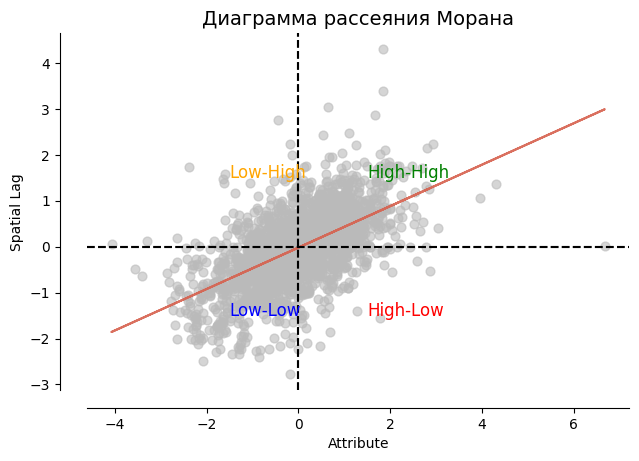

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from splot.esda import moran_scatterplot

# Строим диаграмму Морана
fig, ax = moran_scatterplot(lisa, aspect_equal=True)
ax.set_title("Диаграмма рассеяния Морана", fontsize=14)

# Настроим линии деления на квадранты
mean_x = 0
mean_y = 0
ax.axhline(mean_y, color='k', linestyle='--')
ax.axvline(mean_x, color='k', linestyle='--')

# Подписи квадрантов
ax.text(1.5, 1.5, 'High-High', color='green', fontsize=12)
ax.text(-1.5, 1.5, 'Low-High', color='orange', fontsize=12)
ax.text(-1.5, -1.5, 'Low-Low', color='blue', fontsize=12)
ax.text(1.5, -1.5, 'High-Low', color='red', fontsize=12)

plt.show()


| Квадрант  | Интерпретация                                       |
| --------- | --------------------------------------------------- |
| High-High | Высокое значение и у объекта, и у соседей (кластер) |
| Low-Low   | Низкое значение и у объекта, и у соседей (кластер)  |
| High-Low  | Высокое значение у объекта, но низкое у соседей     |
| Low-High  | Низкое значение у объекта, но высокое у соседей     |


C:\Users\Наталья\AppData\Local\Temp\ipykernel_14588\332833244.py:11: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf_clean)
C:\Users\Наталья\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\libpysal\weights\contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 23 disconnected components.
 There are 18 islands with ids: 50, 74, 75, 79, 80, 81, 341, 388, 662, 726, 881, 908, 1074, 1526, 1602, 1664, 1700, 1809.
  W.__init__(self, neighbors, ids=ids, **kw)


('WARNING: ', 50, ' is an island (no neighbors)')
('WARNING: ', 74, ' is an island (no neighbors)')
('WARNING: ', 75, ' is an island (no neighbors)')
('WARNING: ', 79, ' is an island (no neighbors)')
('WARNING: ', 80, ' is an island (no neighbors)')
('WARNING: ', 81, ' is an island (no neighbors)')
('WARNING: ', 341, ' is an island (no neighbors)')
('WARNING: ', 388, ' is an island (no neighbors)')
('WARNING: ', 662, ' is an island (no neighbors)')
('WARNING: ', 726, ' is an island (no neighbors)')
('WARNING: ', 881, ' is an island (no neighbors)')
('WARNING: ', 908, ' is an island (no neighbors)')
('WARNING: ', 1074, ' is an island (no neighbors)')
('WARNING: ', 1526, ' is an island (no neighbors)')
('WARNING: ', 1602, ' is an island (no neighbors)')
('WARNING: ', 1664, ' is an island (no neighbors)')
('WARNING: ', 1700, ' is an island (no neighbors)')
('WARNING: ', 1809, ' is an island (no neighbors)')


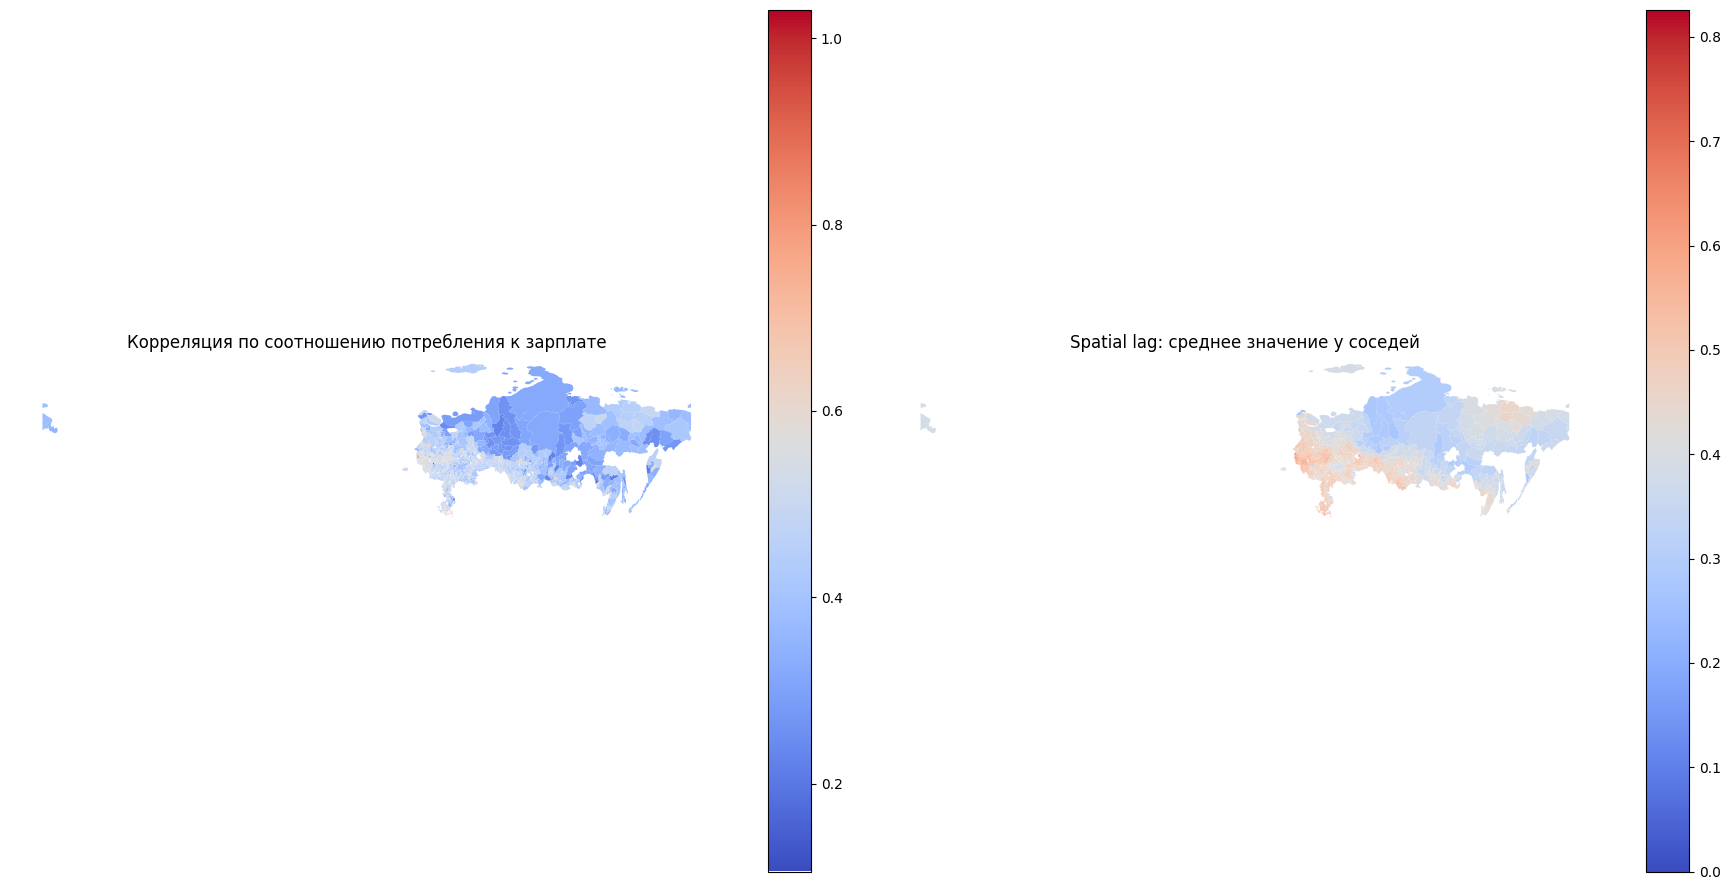

In [11]:
import matplotlib.pyplot as plt
from libpysal.weights import Queen
from libpysal.weights import lag_spatial


# === Шаг 1: Подготовка данных ===
gdf_clean = gdf_merged.dropna(subset=["spending_to_salary_ratio"]).copy()
gdf_clean = gdf_clean.to_crs(epsg=3824)

# === Шаг 2: Пространственные веса и spatial lag ===
w = Queen.from_dataframe(gdf_clean)
w.transform = 'r'
gdf_clean["spending_to_salary_ratio_lag"] = lag_spatial(
    w, gdf_clean["spending_to_salary_ratio"]
)

# === Шаг 3: Построение карт без ограничения по координатам ===
fig, axes = plt.subplots(1, 2, figsize=(18, 9))

# Оригинал
gdf_clean.plot(
    column="spending_to_salary_ratio",
    cmap="coolwarm",
    legend=True,
    ax=axes[0]
)
axes[0].set_title("Корреляция по соотношению потребления к зарплате")
axes[0].axis("off")

# Spatial lag
gdf_clean.plot(
    column="spending_to_salary_ratio_lag",
    cmap="coolwarm",
    legend=True,
    ax=axes[1]
)
axes[1].set_title("Spatial lag: среднее значение у соседей")
axes[1].axis("off")

plt.tight_layout()
plt.show()

C:\Users\Наталья\AppData\Local\Temp\ipykernel_14588\1522897903.py:10: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf_clean)
C:\Users\Наталья\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\libpysal\weights\contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 23 disconnected components.
 There are 18 islands with ids: 50, 74, 75, 79, 80, 81, 341, 388, 662, 726, 881, 908, 1074, 1526, 1602, 1664, 1700, 1809.
  W.__init__(self, neighbors, ids=ids, **kw)


('WARNING: ', 50, ' is an island (no neighbors)')
('WARNING: ', 74, ' is an island (no neighbors)')
('WARNING: ', 75, ' is an island (no neighbors)')
('WARNING: ', 79, ' is an island (no neighbors)')
('WARNING: ', 80, ' is an island (no neighbors)')
('WARNING: ', 81, ' is an island (no neighbors)')
('WARNING: ', 341, ' is an island (no neighbors)')
('WARNING: ', 388, ' is an island (no neighbors)')
('WARNING: ', 662, ' is an island (no neighbors)')
('WARNING: ', 726, ' is an island (no neighbors)')
('WARNING: ', 881, ' is an island (no neighbors)')
('WARNING: ', 908, ' is an island (no neighbors)')
('WARNING: ', 1074, ' is an island (no neighbors)')
('WARNING: ', 1526, ' is an island (no neighbors)')
('WARNING: ', 1602, ' is an island (no neighbors)')
('WARNING: ', 1664, ' is an island (no neighbors)')
('WARNING: ', 1700, ' is an island (no neighbors)')
('WARNING: ', 1809, ' is an island (no neighbors)')


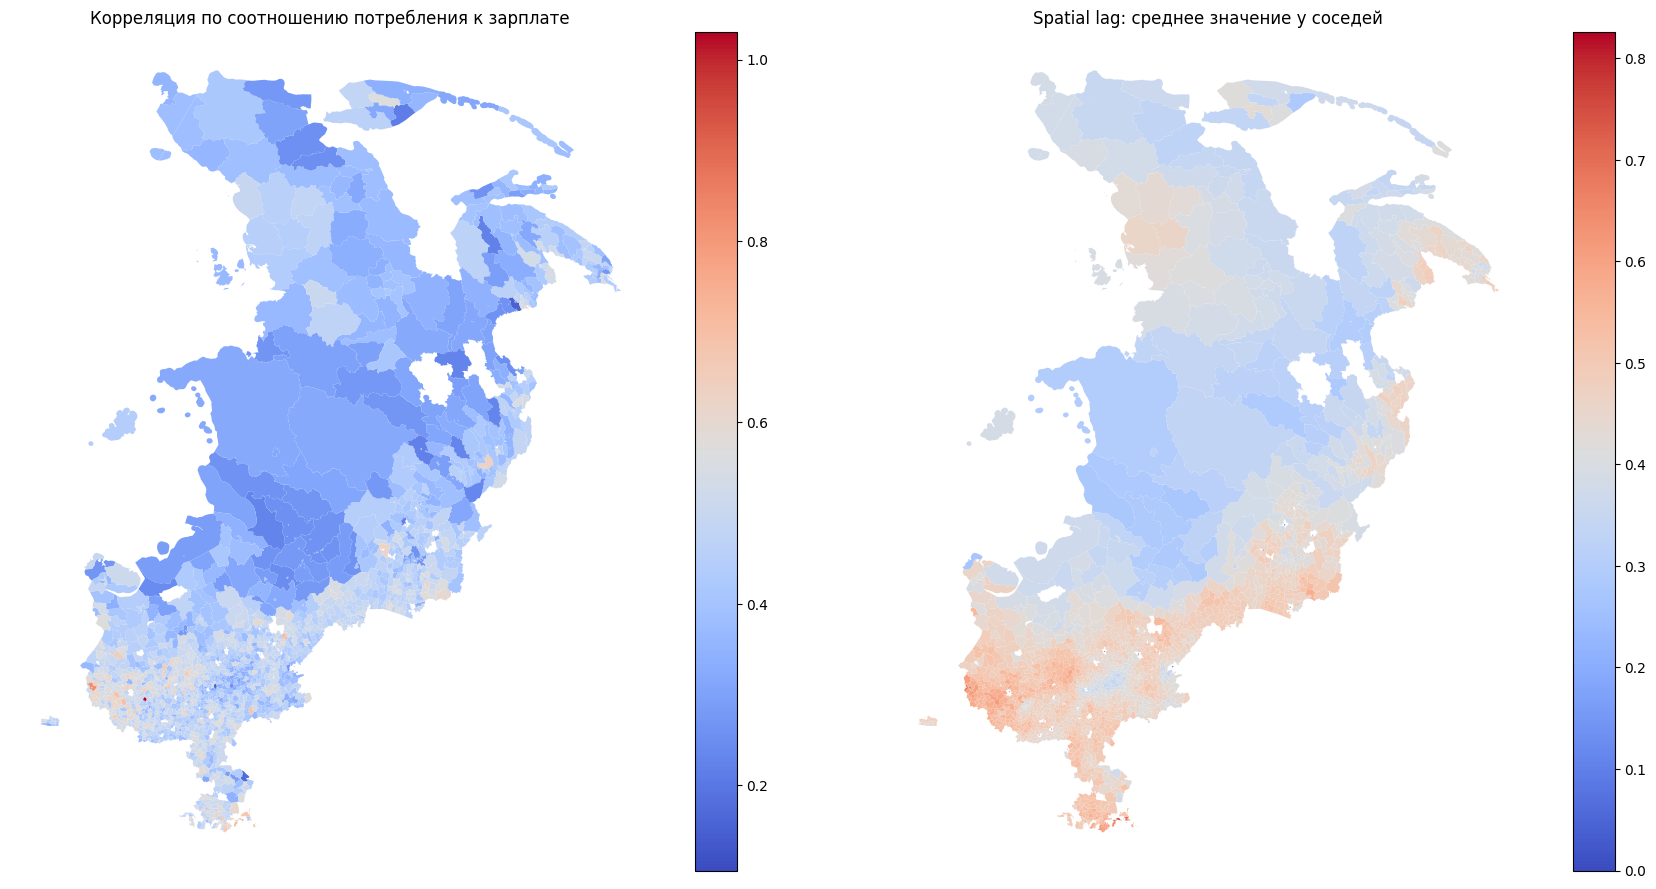

In [12]:
import matplotlib.pyplot as plt
from libpysal.weights import Queen
from esda import moran

# === Шаг 1: Подготовка данных ===
gdf_clean = gdf_merged.dropna(subset=["spending_to_salary_ratio"]).copy()
gdf_clean = gdf_clean.to_crs(epsg=27704)

# === Шаг 2: Пространственные веса и spatial lag ===
w = Queen.from_dataframe(gdf_clean)
w.transform = 'r'
gdf_clean["spending_to_salary_ratio_lag"] = moran.lag_spatial(
    w, gdf_clean["spending_to_salary_ratio"]
)

# === Шаг 3: Построение карт без ограничения по координатам ===
fig, axes = plt.subplots(1, 2, figsize=(18, 9))

# Оригинал
gdf_clean.plot(
    column="spending_to_salary_ratio",
    cmap="coolwarm",
    legend=True,
    ax=axes[0]
)
axes[0].set_title("Корреляция по соотношению потребления к зарплате")
axes[0].axis("off")

# Spatial lag
gdf_clean.plot(
    column="spending_to_salary_ratio_lag",
    cmap="coolwarm",
    legend=True,
    ax=axes[1]
)
axes[1].set_title("Spatial lag: среднее значение у соседей")
axes[1].axis("off")


plt.tight_layout()
plt.show()


In [13]:
# Классы по квантилям для исходного значения
gdf_clean["ratio_class"] = pd.qcut(gdf_clean["spending_to_salary_ratio"], q=5, labels=False)

# Классы по квантилям для spatial lag
gdf_clean["lag_class"] = pd.qcut(gdf_clean["spending_to_salary_ratio_lag"], q=5, labels=False)

# Сохраняем вместе с классами
gdf_clean.to_file(
    "spending_lag_analysis.gpkg", 
    layer="lag_vs_original_with_classes", 
    driver="GPKG"
)

"lisa_significant" = true - статистически значимые
кластеры :
1 - Высокое значение и у объекта, и у соседей (кластер)
2 - Высокое значение у объекта, но низкое у соседей
3 -Низкое значение у объекта, но высокое у соседей
4 - Низкое значение и у объекта, и у соседей (кластер)